# This Looks Like That There
Pretrain CNN Only

In [1]:
import sys
import time
import imp #imp.reload(module)

import numpy as np
from tqdm import trange
from icecream import ic
import scipy.io as sio

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf

import network as network
import experiment_settings
import data_functions
import common_functions

In [2]:
__author__ = "Elizabeth A. Barnes and Randal J Barnes"
__version__ = "1 December 2021"

In [3]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 300.

## Print the detailed system info

In [4]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.4 (default, Apr  9 2021, 09:32:38) 
[Clang 10.0.0 ]
numpy version = 1.19.5
tensorflow version = 2.5.0


## Define experiment settings and directories

In [5]:
EXP_NAME = 'quadrants_testcase'

imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

imp.reload(common_functions)
model_dir, model_diagnostics_dir, vizualization_dir = common_functions.get_exp_directories(EXP_NAME)

## Define the network parameters

In [6]:
RANDOM_SEED          = settings['random_seed']
BATCH_SIZE           = settings['batch_size']
NLAYERS              = settings['nlayers']
NFILTERS             = settings['nfilters']   
DOUBLE_CONV          = settings['double_conv']   
assert(len(NFILTERS)==NLAYERS)

NCLASSES             = settings['nclasses']
PROTOTYPES_PER_CLASS = settings['prototypes_per_class']
NPROTOTYPES          = np.sum(PROTOTYPES_PER_CLASS)

NEPOCHS              = settings['nepochs_pretrain']
LR_INIT              = settings['lr_pretrain']
LR_CALLBACK_EPOCH    = settings['lr_cb_epoch_pretrain']
PATIENCE             = 100

## Initialize

In [7]:
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Get and process the data

In [8]:
imp.reload(data_functions)
DATA_NAME = settings['data_name']
DATA_DIR = settings['data_dir']

if(EXP_NAME[:3]=='mjo'):

    labels, data, lat, lon, time = data_functions.load_mjo_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_mjo_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )        
elif(EXP_NAME[:9]=='quadrants'):
    filename = DATA_DIR + DATA_NAME + '.mat'
    X_train, y_train, X_val, y_val, X_test, y_test, lat, lon = data_functions.get_and_process_data(filename, 
                                                                                        rng, 
                                                                                        colored=settings['colored'],
                                                                                        standardize=settings['standardize'],
                                                                                        shuffle=settings['shuffle'],
                                                                                        )      
    

loading ./data/data_quadrants_testcase.mat
shuffling the data before train/validation/test split.
raw_data        = (1200, 100, 100, 1)
training data   = (960, 100, 100, 1), (960,)
validation data = (240, 100, 100, 1), (240,)
test data       = (0, 100, 100, 1), (0,)
X_mean          = 0.0008956050790393463
X_std           = 0.11342437932997024


In [9]:
proto_class_mask = network.createClassIdentity(PROTOTYPES_PER_CLASS)

prototypes_of_correct_class_train = np.zeros((len(y_train),NPROTOTYPES))
for i in range(0,prototypes_of_correct_class_train.shape[0]):
    prototypes_of_correct_class_train[i,:] = proto_class_mask[:,int(y_train[i])]
    
prototypes_of_correct_class_val   = np.zeros((len(y_val),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_val.shape[0]):
    prototypes_of_correct_class_val[i,:] = proto_class_mask[:,int(y_val[i])]

prototypes_of_correct_class_test   = np.zeros((len(y_test),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_test.shape[0]):
    prototypes_of_correct_class_test[i,:] = proto_class_mask[:,int(y_test[i])]

## Define the training callbacks and metrics

In [10]:
# callbacks
def scheduler(epoch, lr):
    if epoch < LR_CALLBACK_EPOCH:
        return np.round(lr,8)
    else:
        if(epoch % 2 == 0):
            return lr/2.
        else:
            return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)    
    
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', 
    mode='max',
    patience=settings['pretrain_patience'], 
    restore_best_weights=True, 
    verbose=1
)

callbacks_list = [
#     lr_callback,
    es_callback,
]            

# metrics
metrics_list = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
]

## Instantiate the model

In [11]:
__ = imp.reload(network)
tf.keras.backend.clear_session()

model = network.build_model(
    cnn_only=True,    
    nlayers=NLAYERS,
    nfilters=NFILTERS,
    input_shape= X_train.shape[1:],
    output_shape=NCLASSES,
    prototypes_per_class=PROTOTYPES_PER_CLASS,
    network_seed=RANDOM_SEED,
    double_conv=DOUBLE_CONV,
    dense_nodes=settings['dense_nodes'],
    prototype_channels=settings['prototype_channels'],
    kernel_l1_coeff=settings['kernel_l1_coeff'],
    kernel_l2_coeff=settings['kernel_l2_coeff'],
    drop_rate=settings['drop_rate'],
    drop_rate_final=settings['drop_rate_final'],    
    coeff_cluster=0.0,#settings['coeff_cluster'],
    coeff_separation=0.0,#settings['coeff_separation'],
    coeff_l1=0.0,#settings['coeff_l1'],    
)
model.summary()

2
[32, 32]
(100, 100, 1)
3
[5, 5, 5]
35
False
0.0
0.0
0.0
-0.5
True
64
128
0.0
0.0
0.0
0.5
False
Model: "full_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0         
_________________________________________________________________
maxpooling_0 (AveragePooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 50, 50, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________

In [12]:
__ = ic(len(np.where(y_train==0)[0])/len(y_train))

ic| len(np.where(y_train==0)[0])/len(y_train): 0.33541666666666664


In [13]:
# compile the model
print('learning rate = ' + str(LR_INIT))

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=LR_INIT,
#         beta_1=0.9, beta_2=0.999, epsilon=1e-07,
    ),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = metrics_list,
)

# train the model
tf.random.set_seed(RANDOM_SEED)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    batch_size=BATCH_SIZE,
    epochs=NEPOCHS,
    shuffle=True,
    verbose=1,
    callbacks=callbacks_list
)


# save the model
model_filename = model_dir + 'pretrained_model_' + EXP_NAME
common_functions.save_model(model, model_filename)

learning rate = 5e-06
Epoch 1/100
30/30 [==============================] - 3s 80ms/step - loss: 1.5268 - sparse_categorical_accuracy: 0.3417 - val_loss: 0.9556 - val_sparse_categorical_accuracy: 0.4875
Epoch 2/100
30/30 [==============================] - 2s 74ms/step - loss: 1.0319 - sparse_categorical_accuracy: 0.4521 - val_loss: 0.8551 - val_sparse_categorical_accuracy: 0.5458
Epoch 3/100
30/30 [==============================] - 2s 74ms/step - loss: 0.9755 - sparse_categorical_accuracy: 0.5083 - val_loss: 0.7707 - val_sparse_categorical_accuracy: 0.6208
Epoch 4/100
30/30 [==============================] - 2s 77ms/step - loss: 0.8422 - sparse_categorical_accuracy: 0.5865 - val_loss: 0.6719 - val_sparse_categorical_accuracy: 0.6875
Epoch 5/100
30/30 [==============================] - 2s 77ms/step - loss: 0.7653 - sparse_categorical_accuracy: 0.6667 - val_loss: 0.5983 - val_sparse_categorical_accuracy: 0.7333
Epoch 6/100
30/30 [==============================] - 2s 74ms/step - loss: 0.73

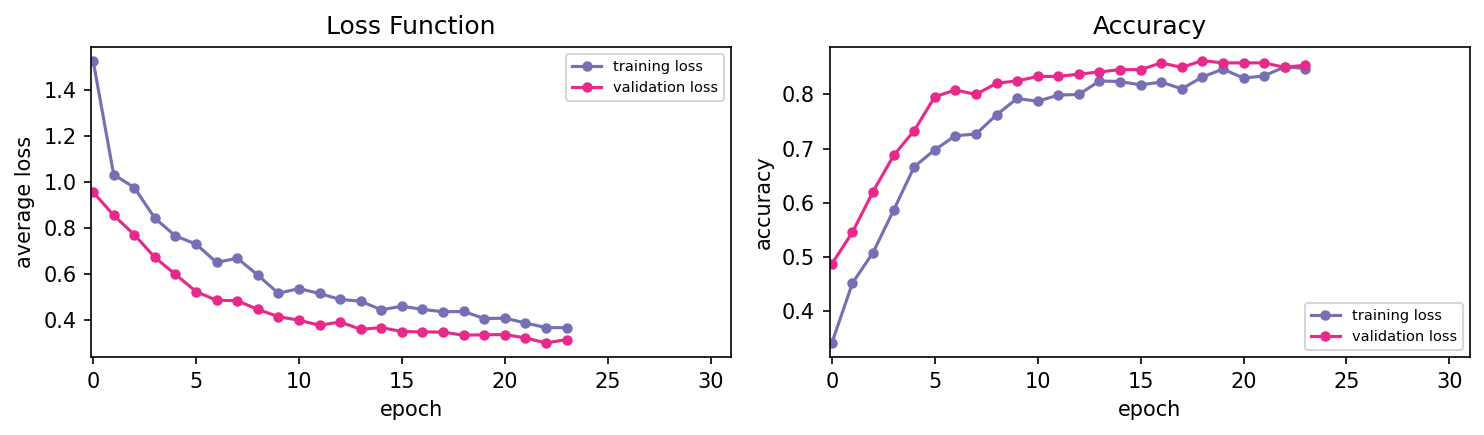

In [14]:
#-------------------------------
# Display the results
best_epoch = np.argmin(history.history['val_loss'])

#---- plot loss and errors ----
trainColor = (117/255., 112/255., 179/255., 1.)
valColor = (231/255., 41/255., 138/255., 1.)
FS = 7
MS = 4

plt.subplots(1,2,figsize=(10, 3))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'o-', color=trainColor, label='training loss', markersize=MS)
plt.plot(history.history['val_loss'], 'o-', color=valColor, label='validation loss', markersize=MS)
# plt.axvline(x=best_epoch, linestyle = '--', color='tab:gray')
plt.title("Loss Function")
plt.ylabel('average loss')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(frameon=True, fontsize=FS)
plt.xlim(-.1, 30+1)

plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'], 'o-', color=trainColor, label='training loss', markersize=MS)
plt.plot(history.history['val_sparse_categorical_accuracy'], 'o-', color=valColor, label='validation loss', markersize=MS)
# plt.axvline(x=best_epoch, linestyle = '--', color='tab:gray')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(frameon=True, fontsize=FS)
plt.xlim(-.1, 30+1)

plt.tight_layout()
plt.savefig(model_diagnostics_dir + 'loss_history_pretrained_model_' + EXP_NAME + '.png', dpi=dpiFig)
plt.show()